### Proposal Report: Power Price Prediction

### Executive Summary 

Our proposed business solution aims to improve the accuracy of the power price prediction for Alberta province which is published by Alberta Electric System Operator(AESO) by developing a scalable machine learning product deployed on the cloud. This product will forecast the hourly energy price 12 hours in advance along with confidence intervals and will also address the lack of interepretibilty and explainability in the current system. This product will be accompanied by an intuitive tableau dashboard showcasing relevant visualizations to enable stakeholders to monitor real-time hourly predictions.

### Data Science Techniques

AESO is an operator service in Alberta that is responsible for managing the power distribution system for the province. This organization publishes relevant data which is used for the computation of market pool price excluding some sensitive information. They also published APIs using which we can access near to real-time data programmatically like price, internal load, etc. However, the values of some of the features are not available in real time which needs to be analyzed based on the historical data alone. Hence the primary sources of data would be the open-source datasets and the APIs.
The current datasets contain ~72,000 rows and ~50 features spanning from 2015 – 2023.
The main target that we are forecasting 12 hours in advance is the **power pool price** which is the balanced average market price for power for the Alberta province and is measured in CAD. It is capped between 0 and 1000 to ensure that the price is not fluctuating and the Alberta electricity market is stable.
Some of the main features that could have a significant impact on the price prediction are given below –
- **Alberta Internal load** - This feature represents the total amount of power load demand within Alberta. The unit of AIL is MegaWatts (MW).
 - **Hourly Profile** - A categorical variable with two values OFF PEAK and ON PEAK. This indicates whether there is a high/low demand for power at the given hour.
- **Region-wise system load** - This represents the total electric power that is distributed to consumers in Alberta in various regions. Alberta is divided into six regions - Calgary, Edmonton, Central, Northeast, South, and Northwest.
- **Season** - A categorical variable of two values - SUMMER and WINTER. This indicates the season that the given hour belongs to.

There are some additional features that we may include in the later iterative stages like power generation and weather data. The stakeholders would be the power buyers or any other industry clients who are interested in making informed decisions about their energy purchases. This product will assist organizations to plan for alternative power source options like generating power on their own on their site. The metrics used in this project will be useful for them to evaluate the performance of the forecasting model.

### EDA

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})

df = pd.read_csv('data/ail_price.csv', parse_dates=['date'], index_col='date')
df = df.sort_values(by='date')

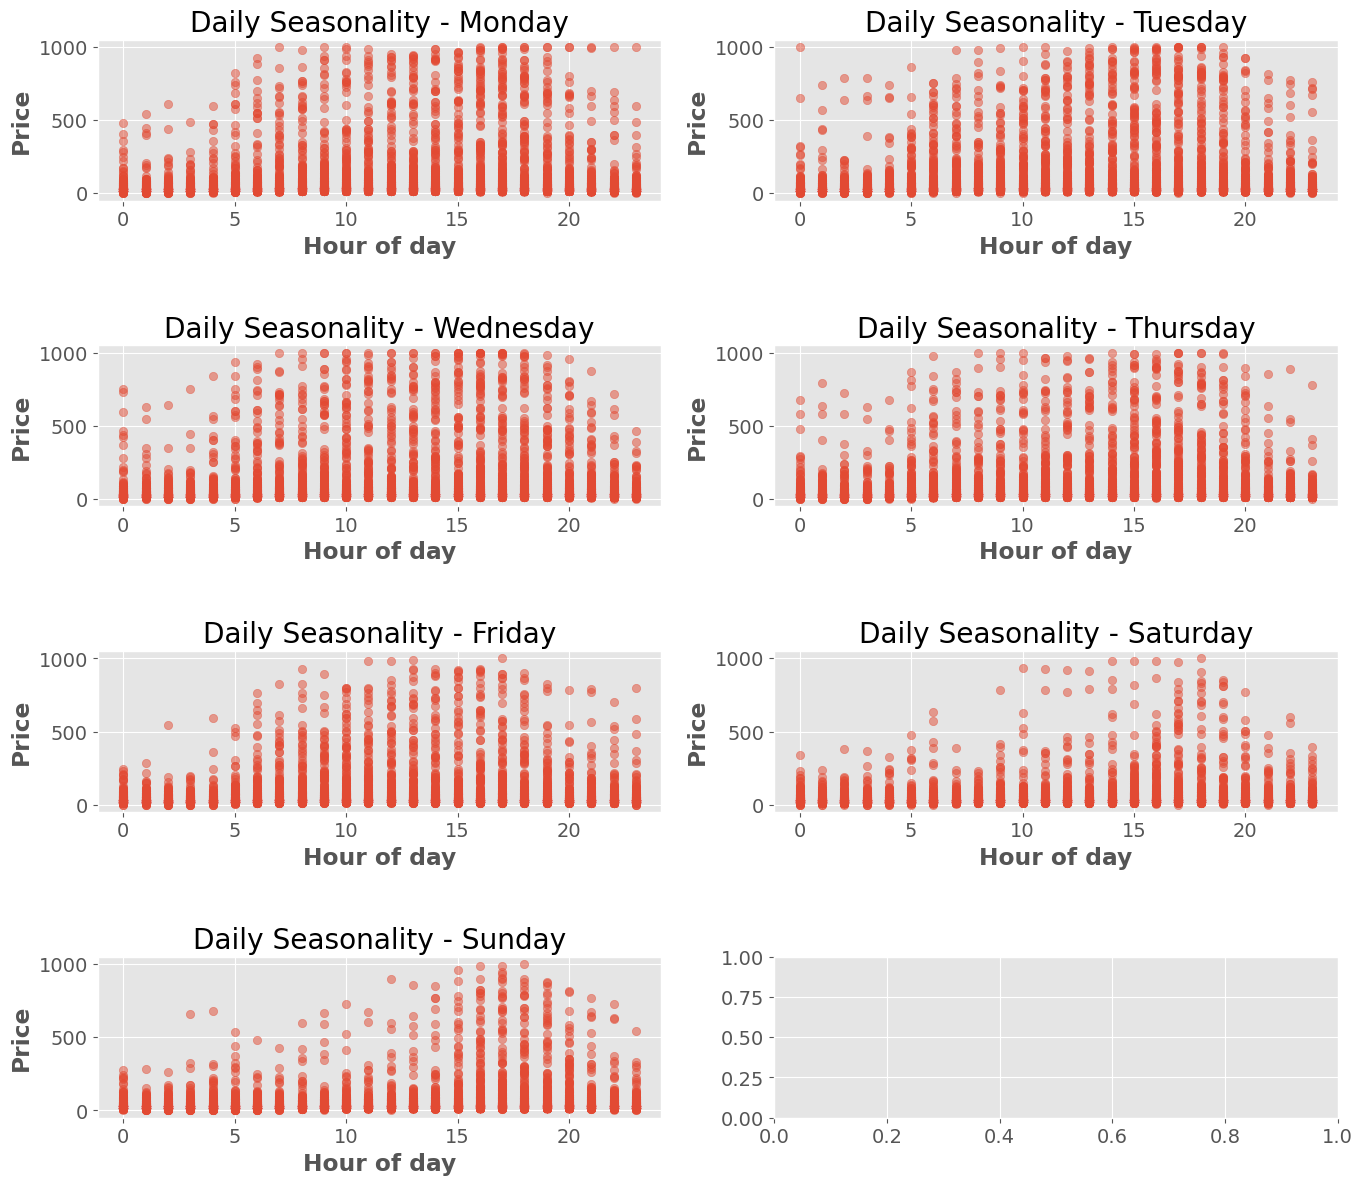

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 14))
plt.subplots_adjust(hspace=0.9)

# Loop through days of the week and plot data
for i, ax in enumerate(axs.flat):
    if i > 6:
        break

    day = df[df.index.dayofweek == i]
    ax.scatter(day.index.hour, day['price'], alpha=0.5)
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Price')
    ax.set_title(f'Daily Seasonality - {day.index[0].strftime("%A")}')

plt.show()

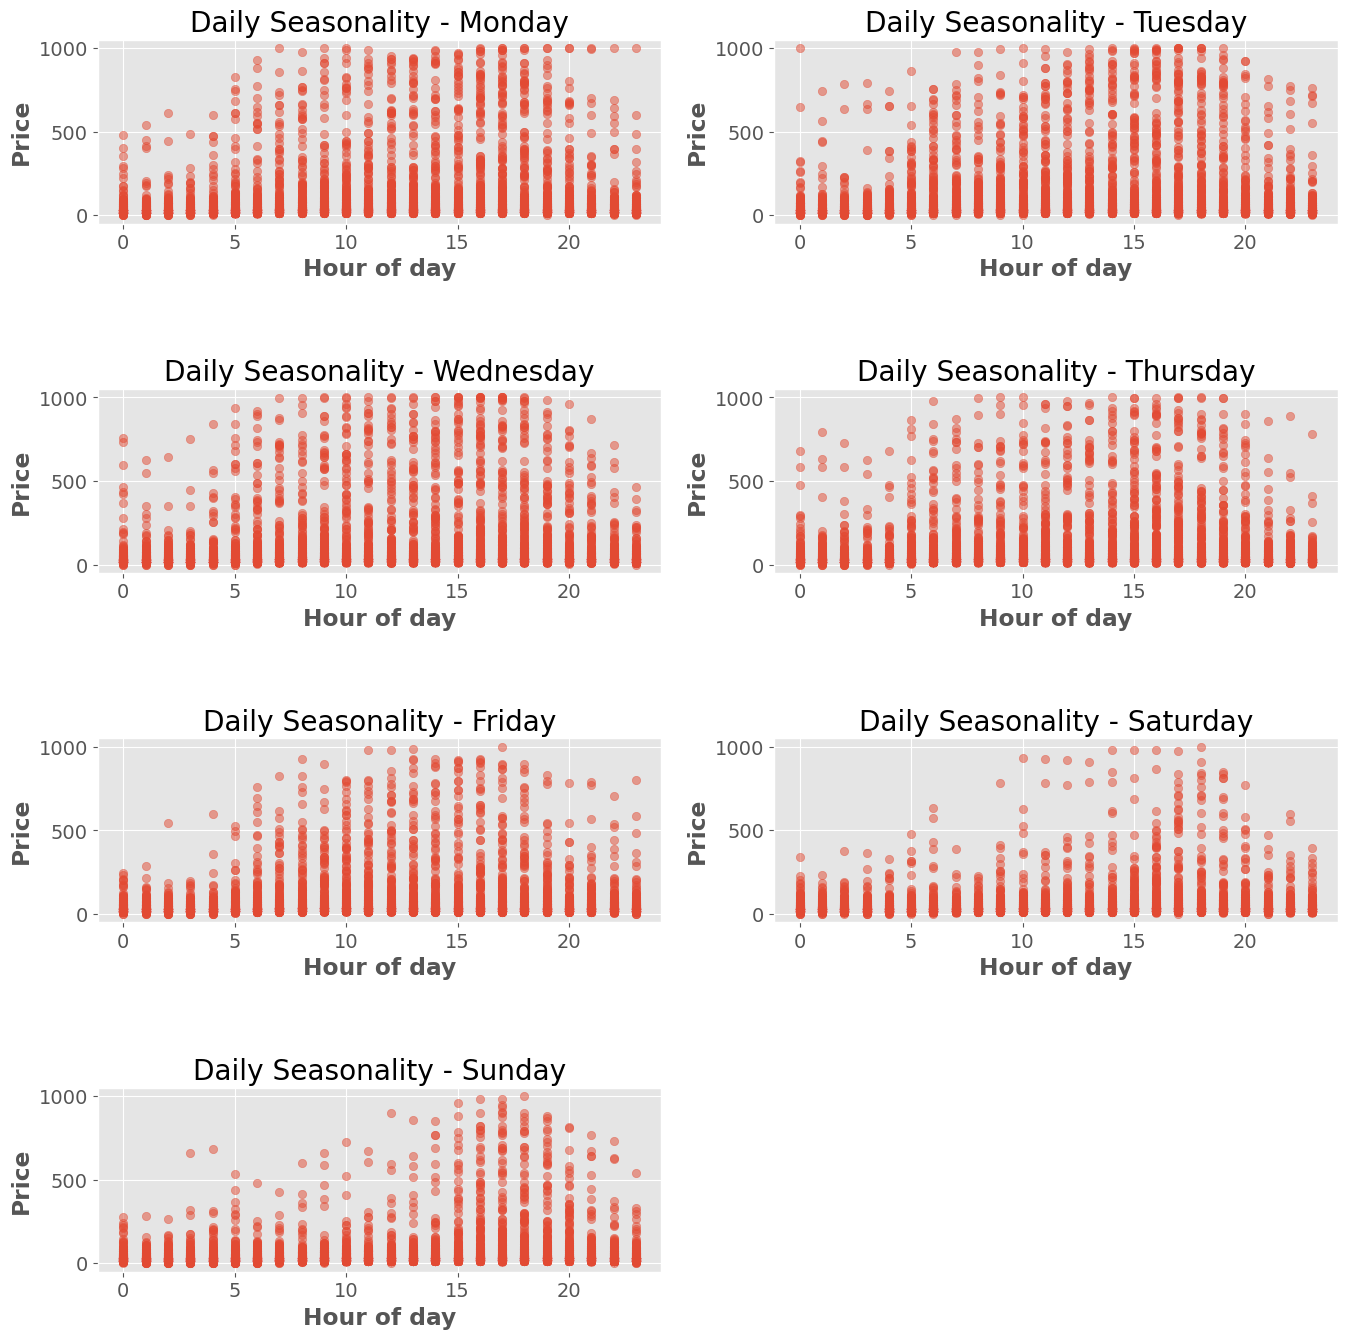

In [13]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
plt.subplots_adjust(hspace=0.9)

# Loop through days of the week and plot data
for i, ax in enumerate(axs.flat):
    if i > 6:
        break

    day = df[df.index.dayofweek == i]
    ax.scatter(day.index.hour, day['price'], alpha=0.5)
    ax.set_xlabel('Hour of day')
    ax.set_ylabel('Price')
    ax.set_title(f'Daily Seasonality - {day.index[0].strftime("%A")}')

# Remove empty subplots
plt.delaxes(axs[3][1])

plt.show()


In [29]:
import pandas as pd
import plotly.graph_objs as go
# Create an interactive plot for the target variable
fig = go.Figure()
trace = go.Scatter(x=df.index, y=df['price'], name='Price', mode='lines')
fig.add_trace(trace)
fig.update_layout(title="Price vs Date", xaxis_title="Date", yaxis_title="Price")
fig.show()

In [32]:
import pandas as pd
import plotly.graph_objs as go

# Create an interactive plot for the target variable
fig = go.Figure()

trace = go.Scatter(x=df.index, y=df['price'], name='Price', mode='lines')
fig.add_trace(trace)

# Set x-axis range to focus on March 2023
fig.update_layout(title="Variation of Energy pool price through time", xaxis_title="Date", yaxis_title="Price", xaxis_range=['2023-03-01', '2023-03-31'])

fig.show()


<Figure size 1000x800 with 0 Axes>

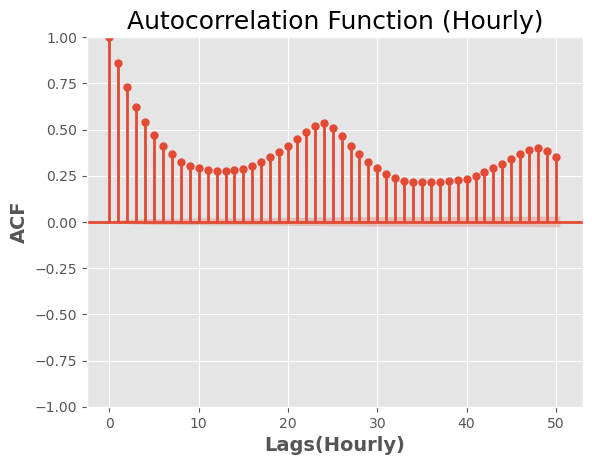

In [27]:
fig = plt.figure(figsize=(10, 8))

# ACF plot
plot_acf(df['price'], lags=50)
plt.title('Autocorrelation Function (Hourly)', fontsize=18)
plt.xlabel('Lags(Hourly)', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.show()

Text(0.5, 0, 'Lag (daily)')

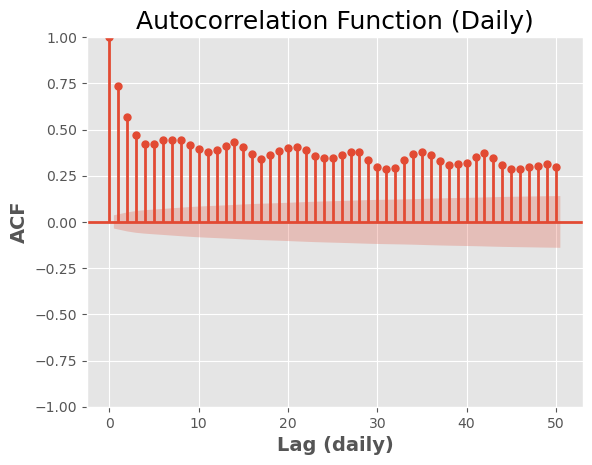

In [28]:
fig = plot_acf(df["price"].resample("D").mean(), lags=50, title=None, bartlett_confint=True)
plt.xlabel('Lags', fontsize=14)
plt.ylabel('ACF', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Autocorrelation Function (Daily)', fontsize=18)
plt.ylabel("ACF")
plt.xlabel("Lag (daily)")